In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('tatamotors.csv')
df.head()

,Volume,Next day %,High %,Low %,Close %
0,400353.0,-0.714279,0.357145,-0.714279,-0.714279
1,226686.0,1.785717,1.785717,0.000000,1.071426
2,318529.0,1.052629,1.052629,-0.350880,0.701749
3,1173507.0,3.125001,3.472227,-0.347225,2.430552
4,681310.0,0.000000,1.010099,-1.683503,-0.336703


In [3]:
X = df.drop(columns='Next day %')
y = df['Next day %']

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [5]:
X_train

,Volume,High %,Low %,Close %
710,12741962.0,8.230570,-0.268093,7.292234
5545,12629045.0,2.130109,-0.287853,0.759928
2133,40642105.0,2.505487,-1.916558,1.587140
558,6589761.0,4.894040,-0.289685,3.750565
5947,42250518.0,1.470593,-3.114185,0.951556
...,...,...,...,...
3772,15690758.0,2.860266,-1.113535,2.091702
5191,9476008.0,2.315855,-0.306060,2.019995
5226,4912743.0,0.799700,-1.385533,-1.069370
5390,4253044.0,0.518135,-2.217619,-0.207254


In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
trf1=ColumnTransformer([
    ('scaler',MinMaxScaler(),[0])
],remainder='passthrough')

In [7]:
trf2 = LinearRegression()

In [8]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2)
])

In [9]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  [0])])),
                ('trf2', LinearRegression())])

In [10]:
X_test.values[0]

array([ 9.05114200e+06,  1.91431816e+00, -3.57037485e-02,  1.18696484e+00])

In [11]:
y_test

3921    1.847384
1295   -2.981971
4693    0.943195
2795   -1.025995
408    -0.800000
          ...   
4988    2.964958
5111   -0.412780
530    -3.361347
5469   -1.738618
5660   -2.333932
Name: Next day %, Length: 1414, dtype: float64

In [12]:
y_pred = pipe.predict(X_test)
y_pred

array([ 1.41318607, -3.95149176,  0.95515471, ..., -0.80746924,
       -1.7414405 , -2.50966672])

In [13]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [14]:
print("MAE",mean_absolute_error(y_test,y_pred))
print("MSE",mean_squared_error(y_test,y_pred))
print("R2 score",r2_score(y_test,y_pred))

MAE 0.8284878599391541
MSE 1.9535567092230384
R2 score 0.774441077706658


In [15]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))

In [23]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10.0),
    'Support Vector Regressor': SVR(C=0.1, epsilon=0.01, kernel='linear'),
    'Random Forest': RandomForestRegressor(max_depth=10,min_samples_split=5,n_estimators=100, random_state=42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5)
}

# Store results
results = []

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessing', trf1),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2
    })

# Show results as DataFrame
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='RMSE'))


                      Model       MAE       MSE      RMSE  R2 Score
2  Support Vector Regressor  0.826938  1.946895  1.395312  0.775210
0         Linear Regression  0.828488  1.953557  1.397697  0.774441
1          Ridge Regression  0.828645  1.954224  1.397936  0.774364
3             Random Forest  0.878608  2.089751  1.445597  0.758716
4             KNN Regressor  0.966830  2.358637  1.535785  0.727670


In [18]:
# tuning ridge
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('preprocessing', trf1),
    ('model', Ridge())
])

params = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

search = GridSearchCV(pipe, params, cv=5)
search.fit(X_train, y_train)
print("Best Ridge alpha:", search.best_params_)


Best Ridge alpha: {'model__alpha': 10}


In [20]:
# tuning svr
from sklearn.svm import SVR

pipe = Pipeline([
    ('preprocessing', trf1),
    ('model', SVR())
])

params = {
    'model__C': [0.1, 1, 10],
    'model__epsilon': [0.01, 0.1, 0.2],
    'model__kernel': ['linear', 'rbf']
}

search = GridSearchCV(pipe, params, cv=3)
search.fit(X_train, y_train)
print("Best svm params:", search.best_params_)

Best svm params: {'model__C': 0.1, 'model__epsilon': 0.01, 'model__kernel': 'linear'}


In [21]:
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([
    ('preprocessing', trf1),
    ('model', RandomForestRegressor(random_state=42))
])

params = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

search = GridSearchCV(pipe, params, cv=3)
search.fit(X_train, y_train)
print("Best randome forest params:", search.best_params_)

Best randome forest params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}


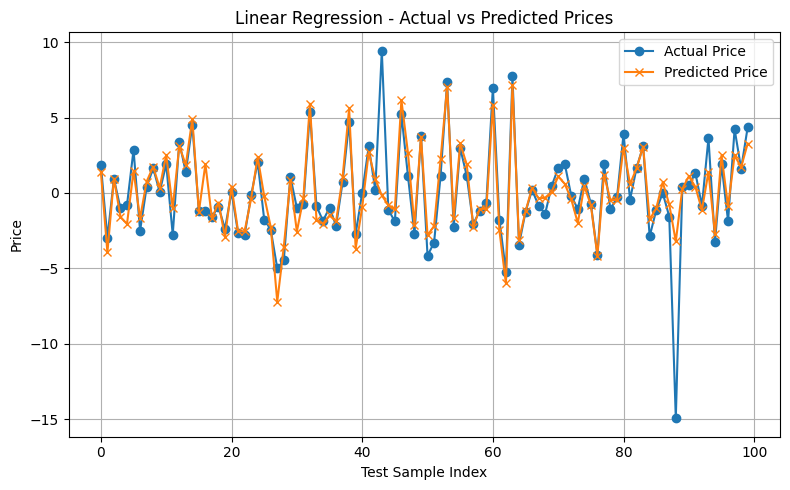

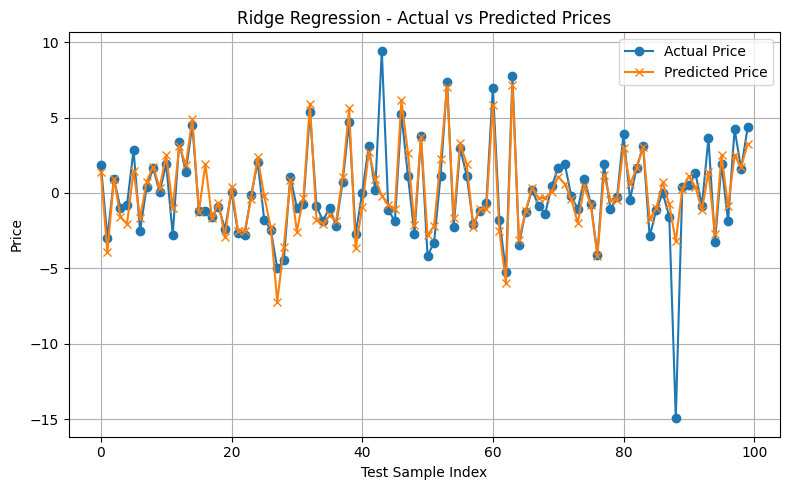

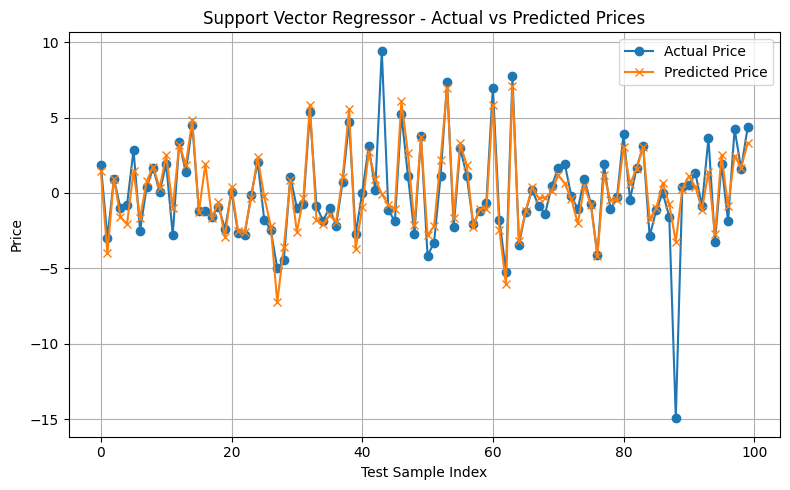

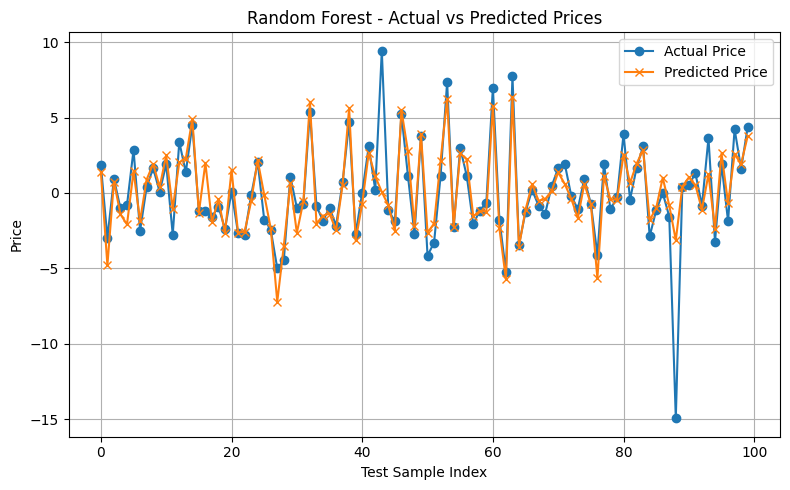

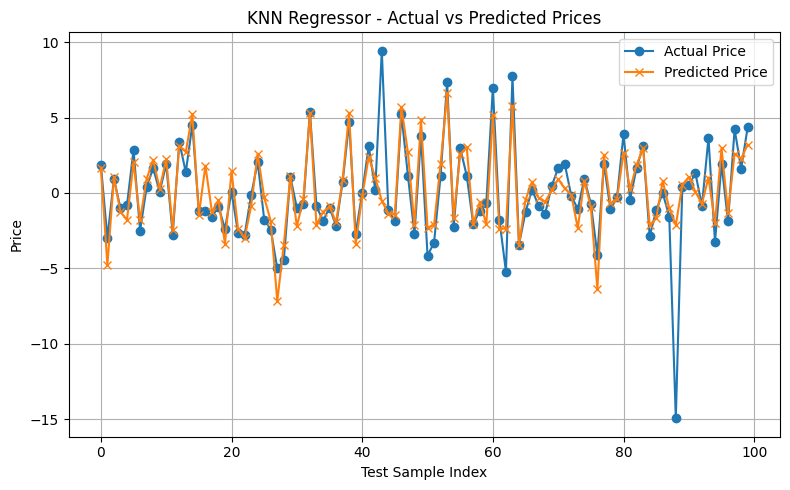

In [25]:
import matplotlib.pyplot as plt

for name, model in models.items():
    
    pipe = Pipeline([
        ('preprocessing', trf1),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values[:100], label='Actual Price', marker='o')
    plt.plot(y_pred[:100], label='Predicted Price', marker='x')
    plt.title(f'{name} - Actual vs Predicted Prices')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
